### Ensemble Classifiers Example

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn import metrics, tree
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier

%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
# Load the dataset
url = "http://facweb.cs.depaul.edu/mobasher/classes/csc478/Data/titanic-trimmed.csv"
titanic = pd.read_csv(url)
titanic.shape

(1309, 9)

In [3]:
# Fill missing 'age' values with the calculated mean
age_mean = titanic.age.mean()
titanic['age'] = titanic['age'].fillna(age_mean)
titanic.dropna(axis = 0, inplace = True)
titanic.shape

(1306, 9)

In [4]:
# Set the 'pid' column as the index of the dataframe
titanic.set_index('pid', drop = True, inplace = True)
titanic.head()

,pclass,survived,sex,age,sibsp,parch,fare,embarked
pid,,,,,,,,
1,1st,1,female,29.000000,0,0,211.337494,Southampton
2,1st,1,male,29.908852,1,2,151.550003,Southampton
3,1st,0,female,2.000000,1,2,151.550003,Southampton
4,1st,0,male,30.000000,1,2,151.550003,Southampton
5,1st,0,female,25.000000,1,2,151.550003,Southampton


In [5]:
# Convert categorical columns into dummy variables
titanic_ssf = pd.get_dummies(titanic)
titanic_ssf.head()

,survived,age,sibsp,parch,fare,pclass_1st,pclass_2nd,pclass_3rd,sex_female,sex_male,embarked_Cherbourg,embarked_Queenstown,embarked_Southampton
pid,,,,,,,,,,,,,
1,1,29.000000,0,0,211.337494,True,False,False,True,False,False,False,True
2,1,29.908852,1,2,151.550003,True,False,False,False,True,False,False,True
3,0,2.000000,1,2,151.550003,True,False,False,True,False,False,False,True
4,0,30.000000,1,2,151.550003,True,False,False,False,True,False,False,True
5,0,25.000000,1,2,151.550003,True,False,False,True,False,False,False,True


In [6]:
titanic_names = titanic_ssf.columns.values # Extract the column names from the dataframe
X = titanic_ssf[titanic_names[1:]] # Assign the features
y = titanic_ssf['survived'] # Assign the target variable

In [7]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 33)

In [8]:
def measure_performance(X, y, clf, show_accuracy = True, show_classification_report = True, show_confussion_matrix = False):

    # Generate predictions for the input data using the classifier
    y_pred = clf.predict(X)   

    if show_accuracy:
        print("Accuracy: {0:.3f}".format(metrics.accuracy_score(y, y_pred)))
        print()

    if show_classification_report:
        print("Classification report")
        print(metrics.classification_report(y, y_pred))
        print()
        
    if show_confussion_matrix:
        print("Confussion matrix")
        print(metrics.confusion_matrix(y, y_pred))

In [9]:
def calc_params(X, y, clf, param_values, param_name, K):
    
    # Convert input to Numpy arrays
    X = np.array(X)
    y = np.array(y)

    # Initialize training and testing score arrays with zeros
    train_scores = np.zeros(len(param_values))
    test_scores = np.zeros(len(param_values))
    
    for i, param_value in enumerate(param_values):

        # Set classifier parameters
        clf.set_params(**{param_name:param_value})
        
        # Initialize the K scores obtained for each fold
        k_train_scores = np.zeros(K)
        k_test_scores = np.zeros(K)
        
        # Create K-Fold Cross-Validation
        cv = KFold(n_splits = K, shuffle = True, random_state = 0)
        
        # Fit the classifier in the corresponding fold and obtain the corresponding accuracy scores
        j = 0
        for train, test in cv.split(X):
            clf.fit(X[train], y[train])
            k_train_scores[j] = clf.score(X[train], y[train])
            k_test_scores[j] = clf.score(X[test], y[test])
            j += 1
            
        # Store the mean of the K-Fold scores
        train_scores[i] = np.mean(k_train_scores)
        test_scores[i] = np.mean(k_test_scores)
        print(param_name, '=', param_value, '/', "Train =", train_scores[i], '/', "Test =", test_scores[i])
       
    # Plot the training and testing scores in a log scale
    plt.plot(param_values, train_scores, label = 'Train', alpha = 0.4, lw = 2, c = 'b')
    plt.plot(param_values, test_scores, label = 'X-Val', alpha = 0.4, lw = 2, c = 'g')
    plt.legend(loc = 7)
    plt.xlabel(param_name + " values")
    plt.ylabel("Mean cross validation accuracy")

    return train_scores, test_scores

---
Decision Tree Classifier

In [10]:
dt = tree.DecisionTreeClassifier(criterion = 'gini')
dt = dt.fit(X_train, y_train)
measure_performance(X_test, y_test, dt, show_confussion_matrix = False, show_classification_report = True)

Accuracy: 0.756

Classification report
              precision    recall  f1-score   support

           0       0.81      0.80      0.80       161
           1       0.68      0.69      0.69       101

    accuracy                           0.76       262
   macro avg       0.74      0.74      0.74       262
weighted avg       0.76      0.76      0.76       262




---
Random Forest Classifier

In [11]:
rf = RandomForestClassifier(n_estimators = 101, random_state = 33, max_depth = 3)
rf = rf.fit(X_train, y_train)
measure_performance(X_test, y_test, rf, show_confussion_matrix = False, show_classification_report = True)

Accuracy: 0.821

Classification report
              precision    recall  f1-score   support

           0       0.82      0.91      0.86       161
           1       0.82      0.68      0.75       101

    accuracy                           0.82       262
   macro avg       0.82      0.80      0.80       262
weighted avg       0.82      0.82      0.82       262




min_samples_leaf = 1 / Train = 0.9743778471764605 / Test = 0.7787587412587412
min_samples_leaf = 2 / Train = 0.9025367446924333 / Test = 0.7959974236290026
min_samples_leaf = 3 / Train = 0.8752399507205684 / Test = 0.7979205005520795
min_samples_leaf = 4 / Train = 0.8618302151677506 / Test = 0.7960158262789842
min_samples_leaf = 5 / Train = 0.8508156891957711 / Test = 0.7979205005520795
min_samples_leaf = 6 / Train = 0.8431524510787038 / Test = 0.7960066249539933
min_samples_leaf = 7 / Train = 0.8383640374752886 / Test = 0.7921604711078395
min_samples_leaf = 8 / Train = 0.8304604188751682 / Test = 0.7931358115568642
min_samples_leaf = 9 / Train = 0.8280666418359454 / Test = 0.7988682370261317
min_samples_leaf = 10 / Train = 0.8225585193249865 / Test = 0.7940743467059257
min_samples_leaf = 11 / Train = 0.8196845543363034 / Test = 0.7883235185866765
min_samples_leaf = 12 / Train = 0.8201638827607942 / Test = 0.791198932646301
min_samples_leaf = 13 / Train = 0.8158530785319315 / Test = 0.

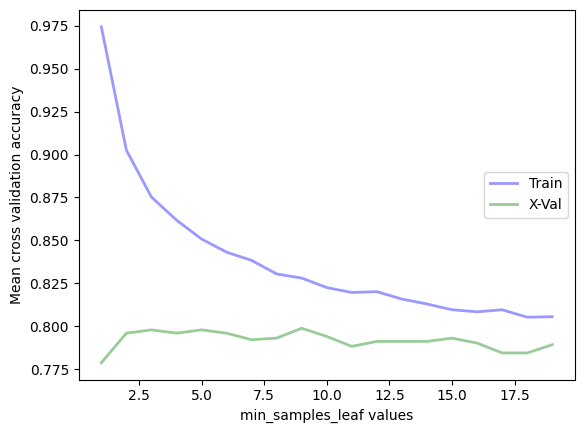

In [12]:
# Explore the impact of 'min_samples_leaf' parameter
min_samples_leaf_range = range(1, 20)
rf = RandomForestClassifier(n_estimators = 101, random_state = 33)
train_scores, test_scores = calc_params(X_train, y_train, rf, min_samples_leaf_range, 'min_samples_leaf', 5)

max_depth = 1 / Train = 0.7792143941781509 / Test = 0.7739648509385352
max_depth = 2 / Train = 0.781849411225396 / Test = 0.7730079131394921
max_depth = 3 / Train = 0.8048362604933674 / Test = 0.7864142436510858
max_depth = 4 / Train = 0.8230372747328308 / Test = 0.8036483253588518
max_depth = 5 / Train = 0.8354874939116982 / Test = 0.8017344497607656
max_depth = 6 / Train = 0.8512924390453543 / Test = 0.7969451601030549
max_depth = 7 / Train = 0.879549608916139 / Test = 0.7988728376886272
max_depth = 8 / Train = 0.899665358278658 / Test = 0.7959928229665072


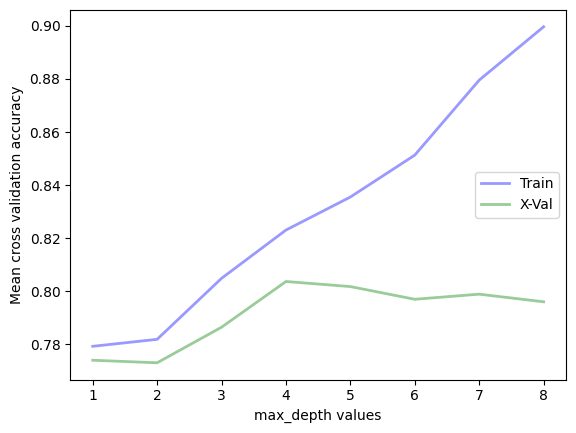

In [13]:
# Explore the impact of 'max_depth' parameter
max_depth_range = [1, 2, 3, 4, 5, 6, 7, 8]
rf = RandomForestClassifier(n_estimators = 101, random_state = 33)
train_scores, test_scores = calc_params(X_train, y_train, rf, max_depth_range, 'max_depth', 5)

n_estimators = 5 / Train = 0.9468389536716042 / Test = 0.7729711078395288
n_estimators = 10 / Train = 0.9588121364925651 / Test = 0.7748895841001104
n_estimators = 15 / Train = 0.9664762341346016 / Test = 0.7806450128818551
n_estimators = 20 / Train = 0.9693501991232847 / Test = 0.7816157526683842
n_estimators = 25 / Train = 0.9719834971205914 / Test = 0.7844911667280089
n_estimators = 30 / Train = 0.9722233045869982 / Test = 0.7796972764078027
n_estimators = 35 / Train = 0.9727020599948428 / Test = 0.7797064777327936
n_estimators = 40 / Train = 0.9731808154026875 / Test = 0.7777834008097166
n_estimators = 45 / Train = 0.9734203363607712 / Test = 0.7749125874125874
n_estimators = 50 / Train = 0.9736592843022089 / Test = 0.7797064777327936
n_estimators = 55 / Train = 0.9738990917686158 / Test = 0.7816203533308796
n_estimators = 60 / Train = 0.9741383262183765 / Test = 0.7797064777327936
n_estimators = 65 / Train = 0.9743778471764605 / Test = 0.7816249539933751
n_estimators = 70 / Train 

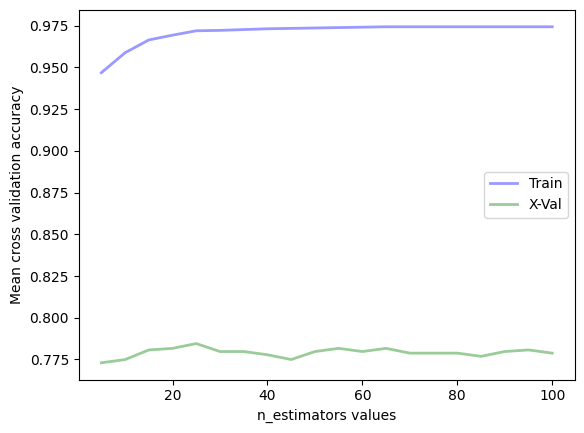

In [14]:
# Explore the impact of 'n_estimators' parameter
n_estimators_range = range(5, 101, 5)
rf = RandomForestClassifier(n_estimators = 10, random_state = 33)
train_scores, test_scores = calc_params(X_train, y_train, rf, n_estimators_range, 'n_estimators', 5)

In [15]:
# Build the best model with optimized parameters
rf = RandomForestClassifier(n_estimators = 25, min_samples_leaf = 8, max_depth = 4)
rf = rf.fit(X_train, y_train)
measure_performance(X_test, y_test, rf, show_confussion_matrix = False, show_classification_report = True)

Accuracy: 0.813

Classification report
              precision    recall  f1-score   support

           0       0.82      0.89      0.85       161
           1       0.80      0.69      0.74       101

    accuracy                           0.81       262
   macro avg       0.81      0.79      0.80       262
weighted avg       0.81      0.81      0.81       262




---
Ada Boost Classifier

In [16]:
ab = AdaBoostClassifier(algorithm = 'SAMME')
ab = ab.fit(X_train, y_train)
measure_performance(X_test, y_test, ab, show_confussion_matrix = False, show_classification_report = True)

Accuracy: 0.790

Classification report
              precision    recall  f1-score   support

           0       0.82      0.84      0.83       161
           1       0.74      0.70      0.72       101

    accuracy                           0.79       262
   macro avg       0.78      0.77      0.78       262
weighted avg       0.79      0.79      0.79       262




n_estimators = 5 / Train = 0.782329599174856 / Test = 0.7806818181818181
n_estimators = 10 / Train = 0.7878368621608458 / Test = 0.7739786529260213
n_estimators = 15 / Train = 0.7909489155659972 / Test = 0.7816341553183659
n_estimators = 20 / Train = 0.7928650832306678 / Test = 0.7845049687154951
n_estimators = 25 / Train = 0.7940626880210869 / Test = 0.783548030916452
n_estimators = 30 / Train = 0.7959788556857577 / Test = 0.783548030916452
n_estimators = 35 / Train = 0.7964578976019254 / Test = 0.7845049687154951
n_estimators = 40 / Train = 0.797177320001146 / Test = 0.7845095693779904
n_estimators = 45 / Train = 0.7974159814342606 / Test = 0.7854665071770335
n_estimators = 50 / Train = 0.7981345443085122 / Test = 0.7845095693779904
n_estimators = 55 / Train = 0.7974159814342606 / Test = 0.7873803827751196
n_estimators = 60 / Train = 0.7986135862246799 / Test = 0.7854665071770335
n_estimators = 65 / Train = 0.7976555023923446 / Test = 0.7864234449760765
n_estimators = 70 / Train = 0.

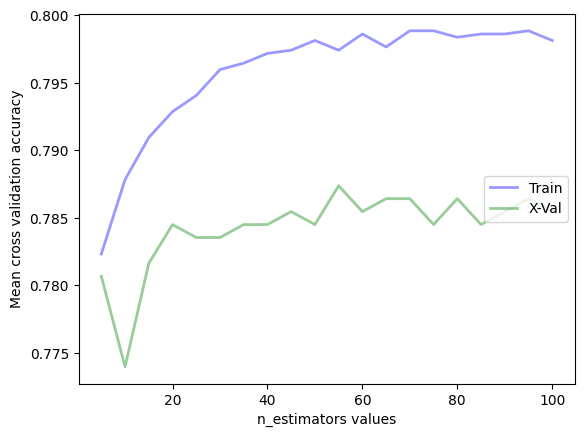

In [17]:
# Explore the impact of 'n_estimators' parameter
n_estimators_range = range(5, 101, 5)
ab = AdaBoostClassifier(algorithm = 'SAMME')
train_scores, test_scores = calc_params(X_train, y_train, ab, n_estimators_range, 'n_estimators', 5)

learning_rate = 0.01 / Train = 0.7806529524682692 / Test = 0.7806772175193227
learning_rate = 0.05 / Train = 0.7806529524682692 / Test = 0.7806772175193227
learning_rate = 0.1 / Train = 0.7806529524682692 / Test = 0.7806772175193227
learning_rate = 0.2 / Train = 0.7861610749792282 / Test = 0.7816387559808612
learning_rate = 0.3 / Train = 0.7868790648368336 / Test = 0.7816387559808612
learning_rate = 0.4 / Train = 0.7866401168953958 / Test = 0.7816387559808613
learning_rate = 0.6 / Train = 0.7916694839985101 / Test = 0.7797248803827751
learning_rate = 0.7 / Train = 0.7962183766438414 / Test = 0.7826002944423995
learning_rate = 0.8 / Train = 0.7952614388447985 / Test = 0.7940835480309165
learning_rate = 0.9 / Train = 0.796937226026416 / Test = 0.7902511961722488
learning_rate = 1.0 / Train = 0.7981345443085122 / Test = 0.7845095693779904
learning_rate = 1.3 / Train = 0.7978955963670745 / Test = 0.7845049687154951
learning_rate = 1.5 / Train = 0.8043615162020457 / Test = 0.783543430253956

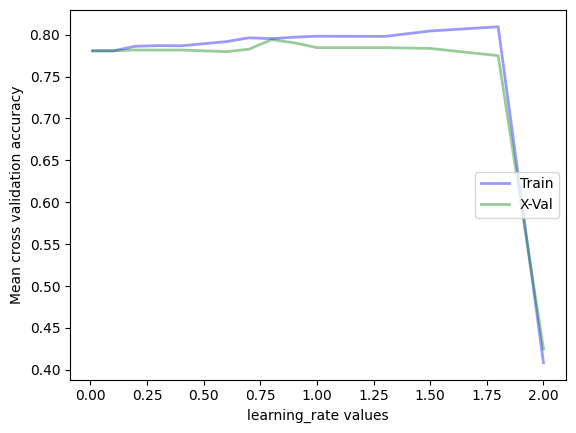

In [18]:
# Explore the impact of 'learning_rate' parameter
learning_rate_range = [0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.6, 0.7, 0.8, 0.9, 1.0, 1.3, 1.5, 1.8, 2.0]
ab = AdaBoostClassifier(algorithm = 'SAMME')
train_scores, test_scores = calc_params(X_train, y_train, ab, learning_rate_range, 'learning_rate', 5)

In [19]:
# Explore the best parameters using a Grid Search
ab = AdaBoostClassifier(algorithm = 'SAMME')
parameters = {'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.6, 0.7, 0.8, 0.9, 1.0, 1.3, 1.5, 1.8, 2.0],
              'n_estimators': range(5, 101, 5)}
gs = GridSearchCV(ab, parameters, cv = 5)
gs.fit(X_train, y_train)
print(gs.best_params_)
print(gs.best_score_)

{'learning_rate': 1.8, 'n_estimators': 65}
0.7988360323886641


In [20]:
# Build the best model with optimized parameters
ab = AdaBoostClassifier(algorithm = 'SAMME', n_estimators = 65, learning_rate = 1.8)
ab = ab.fit(X_train, y_train)
measure_performance(X_test, y_test, ab, show_confussion_matrix = False, show_classification_report = True)

Accuracy: 0.760

Classification report
              precision    recall  f1-score   support

           0       0.81      0.80      0.80       161
           1       0.68      0.70      0.69       101

    accuracy                           0.76       262
   macro avg       0.75      0.75      0.75       262
weighted avg       0.76      0.76      0.76       262




---
Gradient Boosting Classifier

In [21]:
gb = GradientBoostingClassifier(n_estimators = 45, learning_rate = 1.0, max_depth = 3, random_state = 0)
gb.fit(X_train, y_train)
gb.score(X_test, y_test)

0.8129770992366412

---
Bagging Classifier

In [22]:
bagging = BaggingClassifier(KNeighborsClassifier(), max_samples = 0.5, max_features = 0.5, n_estimators = 25, random_state = 5)
bagging.fit(X_train, y_train)
bagging.score(X_test, y_test)

0.8129770992366412